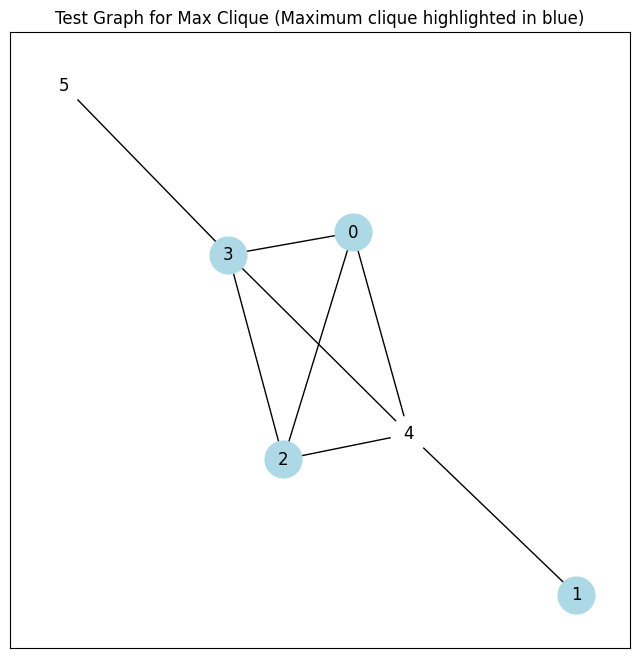

In [11]:
import networkx as nx
import random
import matplotlib.pyplot as plt
# Create a graph with known maximum clique
def generate_test_graph():
    edge_probability = 0.3  # Probability of edge creation
    n_nodes = 6  # Increased number of nodes
    G = nx.gnp_random_graph(n_nodes, edge_probability, seed=42)
    edge_weights = {(u, v): random.uniform(0.5, 2.0) for (u, v) in G.edges()}
    nx.set_node_attributes(G, edge_weights, 'weight')
    return G, edge_weights

G, weights = generate_test_graph()

# Visualization of the graph with maximum clique highlighted
def plot_graph(G):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8,8))
    # Draw the main graph
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    # Draw nodes with different colors for the maximum clique
    max_clique_nodes = [0,1,2,3]  # Known maximum clique
    other_nodes = list(set(G.nodes()) - set(max_clique_nodes))
    nx.draw_networkx_nodes(G, pos, nodelist=max_clique_nodes,
                          node_color='lightblue', node_size=700)
    nx.draw_networkx_nodes(G, pos, nodelist=other_nodes,
                          node_color='white', node_size=700)
    plt.title("Test Graph for Max Clique (Maximum clique highlighted in blue)")
    plt.show()
plot_graph(G)

In [12]:
from max_clique_qaoa.problem_setup.utils import get_QUBO_from_graph, get_hamiltonian_from_QUBO
qubo = get_QUBO_from_graph(G, weights)
print(qubo)

{(0, 1): 10, (0, 0): 0.3706610665778871, (2, 2): 0.8525208178201307, (0, 2): -1.831001563090298, (3, 3): 0.5788158074899413, (0, 3): -0.824072595688111, (4, 4): 0.836420204812072, (0, 4): -0.7413221331557742, (0, 5): 10, (1, 2): 10, (1, 3): 10, (1, 1): 0.6934448903354403, (1, 4): -1.3868897806708806, (1, 5): 10, (2, 3): -0.9920604493172038, (2, 4): -1.7050416356402613, (2, 5): 10, (3, 4): -1.672840409624144, (5, 5): 0.5788158074899413, (3, 5): -1.1576316149798827, (4, 5): 10}


Best solution found (SA): {0: np.int8(1), 1: np.int8(0), 2: np.int8(1), 3: np.int8(1), 4: np.int8(1), 5: np.int8(0)}
Energy: -5.127920889815762
Maximum weighted clique found (SA): [0, 2, 3, 4]
Clique size (SA): 4
Clique weight (SA): 7.766338786515793

Exact maximum weighted clique: [3, 0, 2, 4]
Exact clique size: 4
Exact clique weight: 7.766338786515794


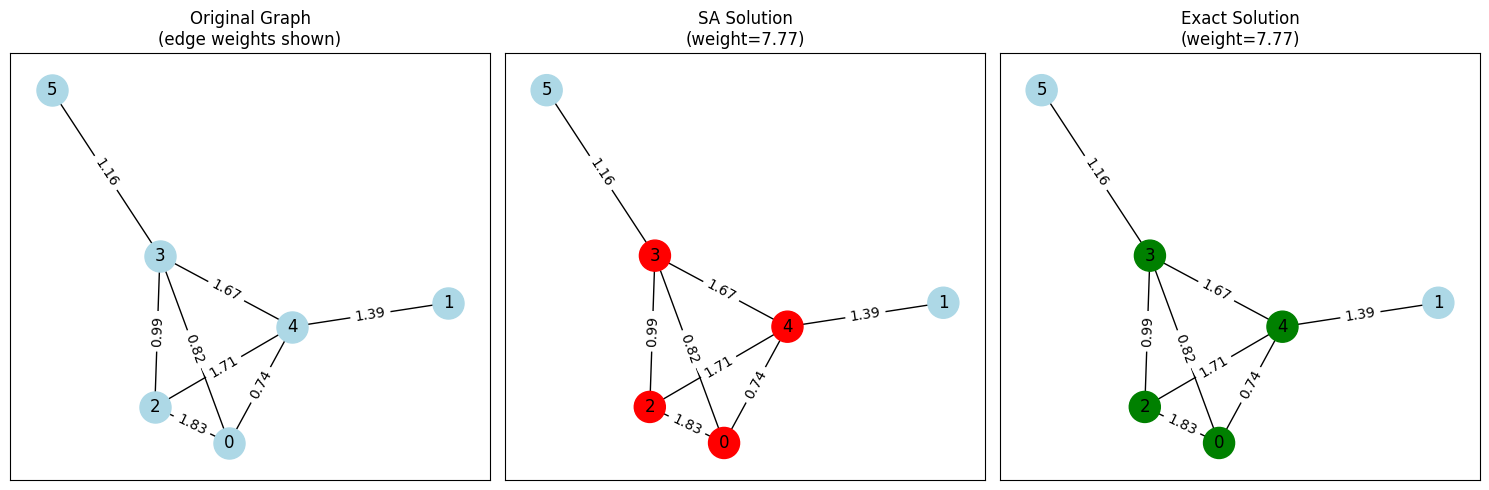

In [13]:
import dimod
from networkx.algorithms.clique import find_cliques
edge_weights = weights
n = len(G.nodes())

# Create BQM from QUBO
bqm = dimod.BinaryQuadraticModel.from_qubo(qubo)
# Run simulated annealing using dimod's built-in sampler
sampler = dimod.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=200)
# Get the best solution
best_solution = sampleset.first.sample
print("Best solution found (SA):", best_solution)
print("Energy:", sampleset.first.energy)
# Extract the weighted clique from SA
clique_sa = [node for node in range(n) if best_solution[node] == 1]
clique_weight_sa = sum(edge_weights.get((min(u,v), max(u,v)), 0)
                      for u in clique_sa for v in clique_sa if u < v)
print("Maximum weighted clique found (SA):", clique_sa)
print("Clique size (SA):", len(clique_sa))
print("Clique weight (SA):", clique_weight_sa)
# Find exact solution using NetworkX and weights
all_cliques = list(find_cliques(G))
max_clique = max(all_cliques,
                 key=lambda clique: sum(edge_weights.get((min(u,v), max(u,v)), 0)
                                      for u in clique for v in clique if u < v))
max_clique_weight = sum(edge_weights.get((min(u,v), max(u,v)), 0)
                       for u in max_clique for v in max_clique if u < v)
print("\nExact maximum weighted clique:", max_clique)
print("Exact clique size:", len(max_clique))
print("Exact clique weight:", max_clique_weight)
# Plotting
plt.figure(figsize=(15, 5))
# Plot original graph with edge weights
plt.subplot(131)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
edge_labels = {(u,v): f"{edge_weights[(u,v)]:.2f}" for (u,v) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Original Graph\n(edge weights shown)")
# Plot graph with highlighted SA clique
plt.subplot(132)
node_colors = ['red' if node in clique_sa else 'lightblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"SA Solution\n(weight={clique_weight_sa:.2f})")
# Plot graph with highlighted exact clique
plt.subplot(133)
node_colors = ['green' if node in max_clique else 'lightblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"Exact Solution\n(weight={max_clique_weight:.2f})")
plt.tight_layout()
plt.show()

In [14]:
from QAOA import qaoa_trotter
hamiltonian = get_hamiltonian_from_QUBO(qubo)
n_qubits = len(G.nodes())
qaoa_states = qaoa_trotter(hamiltonian, n_qubits=n_qubits, n_steps=3, n_trotter=3)

In [15]:
print(qaoa_states)

OptimizerStateNFT(params=array([195.9858243 , 427.5554853 , 245.53471465, 314.69028265,
       181.16469449, 390.21708219]), cost=np.float64(-6.0352290253512075), status=<OptimizerStatus.CONVERGED: 3>, niter=1685, funcalls=20536, gradcalls=0)


In [16]:
clique_sa = [node for node in range(n) if qaoa_states.params[node] < 350]
clique_weight_sa = sum(edge_weights.get((min(u,v), max(u,v)), 0)
                      for u in clique_sa for v in clique_sa if u < v)
max_clique = max(all_cliques,
                 key=lambda clique: sum(edge_weights.get((min(u,v), max(u,v)), 0)
                                      for u in clique for v in clique if u < v))
max_clique_weight = sum(edge_weights.get((min(u,v), max(u,v)), 0)
                       for u in max_clique for v in max_clique if u < v)

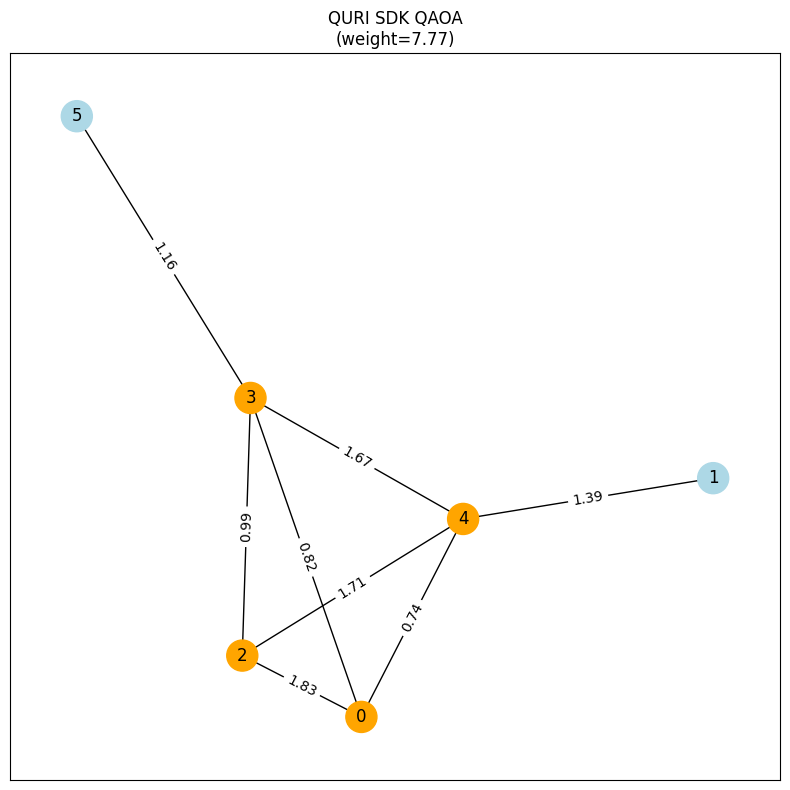

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(111)
node_colors = ['orange' if node in clique_sa else 'lightblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"QURI SDK QAOA\n(weight={max_clique_weight:.2f})")
plt.tight_layout()
plt.show()

In [8]:
print(clique_sa)

[]
